
### Import Base Packages

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import os
from pathlib import Path
import chardet
import numpy as np

### Define Working Directory and get Filesize

In [2]:
data_folder = Path(r"C:\Users\finns\Documents\CAS Machine Intelligence_Cdrive\Deep Learning\Projekt")
os.chdir(data_folder)
os.path.getsize('tri_Data.csv')

2099333

### Determine Encoding of File

In [3]:
data_folder = Path(r"C:\Users\finns\Documents\CAS Machine Intelligence_Cdrive\Deep Learning\Projekt")
os.chdir(data_folder)

rawdata = open("tri_Data.csv", 'rb').read(500000) #Judge format according to first 500k bytes
result = chardet.detect(rawdata)
charenc = result['encoding']
print(charenc) #FileEncoding is ISO-8859-1 (Latin-1)

ISO-8859-1


### Import File and Recode Variable Classes

In [4]:
df = pd.read_csv("tri_Data.csv", sep = ";", header = 0, encoding=charenc)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30319 entries, 0 to 30318
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   subj_id    30319 non-null  int64  
 1   yob        29168 non-null  float64
 2   age_y      20926 non-null  float64
 3   nat        30319 non-null  object 
 4   gender     30319 non-null  object 
 5   race_id    30319 non-null  int64  
 6   race_inf   30319 non-null  object 
 7   race_date  21761 non-null  object 
 8   race_y     21761 non-null  float64
 9   race_m     21761 non-null  float64
 10  time       25975 non-null  object 
 11  rank       30319 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 2.8+ MB


In [5]:
df['race_date'] = pd.to_datetime(df['race_date'])
df['subj_id'] = df['subj_id'].astype(str)
df['race_id'] = df['race_id'].astype(str)


### Get Overview of Dataset

In [6]:
df.sample(5)

,subj_id,yob,age_y,nat,gender,race_id,race_inf,race_date,race_y,race_m,time,rank
19916,1737,1981.0,NaN,ENG,Women,1141,Madrid 2009,NaT,NaN,NaN,NaN,DNF
5710,853,NaN,NaN,ITA,Men,314,Karlovy Vary 2016,2016-08-28,2016.0,8.0,NaN,LAP
23107,1038,1983.0,24.0,LUX,Women,1072,Kitzbühel 2007,2007-07-22,2007.0,7.0,01:58:16,33
22978,2249,1984.0,23.0,NED,Men,552,Salford 2007,2007-07-29,2007.0,7.0,NaN,DNS
22808,1874,1979.0,28.0,BRA,Men,653,Tiszaújváros 2007,2007-11-08,2007.0,8.0,01:49:50,24


In [7]:
pd.DataFrame(
    {'AnyNAN':df.isnull().any(),
     'SumOfNAN':df.isnull().sum(axis = 0),
     'UniqueEntries': df.nunique()
    })

,AnyNAN,SumOfNAN,UniqueEntries
subj_id,False,0,3903
yob,True,1151,45
age_y,True,9393,33
nat,False,0,114
gender,False,0,2
race_id,False,0,1489
race_inf,False,0,745
race_date,True,8558,504
race_y,True,8558,32
race_m,True,8558,8


For lots of Races there are only the first 10 Ranks registered. Furthermore, there are lots of "special rankings" like "DNF => Did not Finish" registered. 

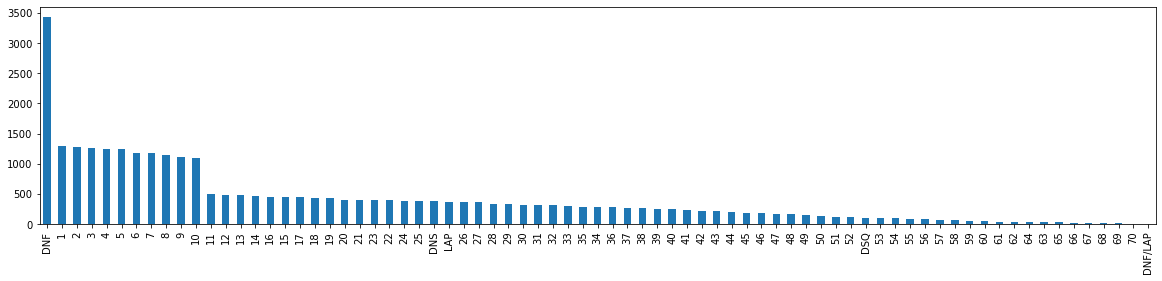

In [8]:
df["rank"].value_counts().plot.bar(figsize=(20,4))
plt.show()
#DNF = Did not Finish
#DNS = Did not Start
#DSQ = Disqualified
#LAP = Ueberrundet

Below plot shows, that there are only few Persons (subj_ids), that are registered for more than 10 Triathlon Contests.

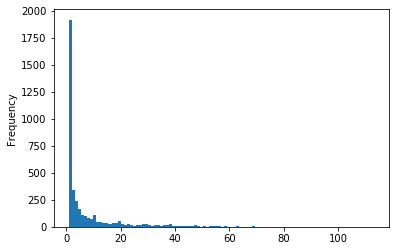

In [9]:
subjRaceNum = df["subj_id"].value_counts().sort_values(ascending=True)
subjRaceNum.plot.hist(bins=100)

Below Plot shows Age Distribution of Triathlon participants is right skewed. 

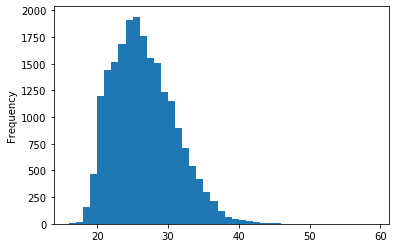

In [10]:
# df['age_y'].value_counts().plot.bar(figsize=(20,4))
binCount = df['age_y'].max() - df['age_y'].min()
df['age_y'].plot.hist(bins=int(binCount), alpha=1)

Below Histogram shows, that most races have 10 Entries or less. Only for few races there are more than 10 entries in the triathlon data. Probably there were only Top 10 Participants registered for many races.

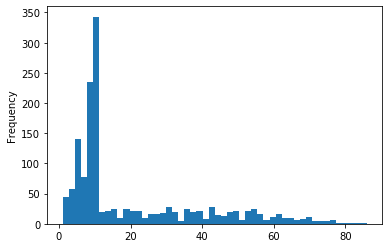

In [11]:
#Checking number of participants per Race, there seem to be lots fo races with 10 or less participants
#Probably the collection of results isn't complete
entriesPerRace = df.groupby(['race_id'])['subj_id'].count()
entriesPerRace.plot.hist(bins=50, alpha=1)

As there are some races, that have even less entries than 10, I want to check a couple of exmpales. Below table shows, that for some races indeed entries aren't complete. 

In [12]:
df[df['race_id']=="35"]


,subj_id,yob,age_y,nat,gender,race_id,race_inf,race_date,race_y,race_m,time,rank
10382,966,1994.0,NaN,FRA,Men,35,Antalya 2014,NaT,NaN,NaN,01:46:52,2
10383,1548,1986.0,NaN,RUS,Men,35,Antalya 2014,NaT,NaN,NaN,01:47:17,3
10384,723,1986.0,NaN,GER,Men,35,Antalya 2014,NaT,NaN,NaN,01:48:50,10


### Data Cleanup and Recoding for Variable "rank"

Later on I want to try to forcast rank as categorical as well as a continuous variable. In case of rank as a continuous variable I will need to standardize the "rank" variable, because (as shown above) number of registered entries per race are vastly different. Furthermore, I want to recode all special rank entries to "last rank" of the respective number of entries per competition. 

In [13]:
#create variable with number of participants for each race_id
entries = df.groupby(["race_id"])["subj_id"].transform("count")
df['entries'] = entries

# Create 2 Column Table that shows the lowest rank entry for each race Id
idx = df['rank'].isin(['DNF','DNS','LAP','DSO','DNF/LAP','DSQ'])
dfRaceAndRank = df.loc[-idx,['race_id','rank']]
dfRaceAndRank['rank'] = pd.to_numeric(dfRaceAndRank['rank']) 
maxRank = dfRaceAndRank.groupby(["race_id"])["rank"].max()

#Create Dictionary for vlookup
maxRankDict = dict(zip(maxRank.index,maxRank.values))

#Create variable with maximum rank entry for each line of df
df['maxRank']= df['race_id'].map(maxRankDict)

# Some race_ids have less entries than there are ranks. In those cases fill in max rank as "number of particpants"
df['participants'] = np.where(df['maxRank'] > df['entries'], df['maxRank'], df['entries'])

#Replace non-numeric ranks with "last rank" according to number of participants
df['rank'] = np.where(df['rank'].isin(['DNF','DNS','LAP','DSO','DNF/LAP','DSQ']), df['participants'], df['rank'])

#Change Variable "Rank" to numeric Variable
df['rank'] = df[['rank']].apply(pd.to_numeric)

#Create Variable with normalized Rank
df['rankNorm'] = df['rank']/df['participants']

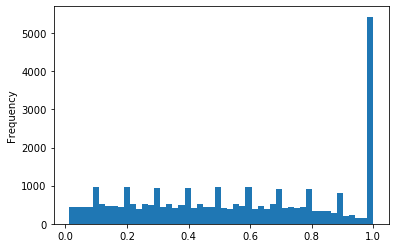

In [14]:
df['rankNorm'].plot.hist(bins=50, alpha=1)

### Data Cleanup and Recoding for Variables "race_y" and "race_inf"

The variables "race_y" and "age_y" that I want to use for my models have lots of nan's

In [15]:
pd.DataFrame(
    {'AnyNAN':df.isnull().any(),
     'SumOfNAN':df.isnull().sum(axis = 0),
     'UniqueEntries': df.nunique()
    })

,AnyNAN,SumOfNAN,UniqueEntries
subj_id,False,0,3903
yob,True,1151,45
age_y,True,9393,33
nat,False,0,114
gender,False,0,2
race_id,False,0,1489
race_inf,False,0,745
race_date,True,8558,504
race_y,True,8558,32
race_m,True,8558,8


Looking at some examples where "race_y" is missing, you can see that the missing race dates can often be parsed from the race name (race_inf). Which I will do in the second chunk below.

In [16]:
df[df['race_y'].isnull()].sample(5)

,subj_id,yob,age_y,nat,gender,race_id,race_inf,race_date,race_y,race_m,time,rank,entries,maxRank,participants,rankNorm
3815,3492,1996.0,NaN,USA,Women,1327,"Sarasota, FL 2017",NaT,NaN,NaN,02:16:00,16.0,30,20.0,30.0,0.533333
357,64,1983.0,NaN,JPN,Women,1180,Miyazaki 2019,NaT,NaN,NaN,01:59:32,1.0,49,41.0,49.0,0.020408
3593,2878,1992.0,NaN,CRC,Men,507,Playa Hermosa 2018,NaT,NaN,NaN,02:14:42,9.0,17,13.0,17.0,0.529412
22298,246,1971.0,NaN,ENG,Women,895,Eilat 2007,NaT,NaN,NaN,NaN,48.0,34,48.0,48.0,1.000000
5288,1736,1989.0,NaN,ENG,Women,747,Abu Dhabi 2017,NaT,NaN,NaN,02:03:46,2.0,30,27.0,30.0,0.066667


In [17]:
df['race_y1'] = df['race_inf'].str.extract(r'(\d{4})', expand = True) #Extract Year from Event Name to variable race_y1
df['race_y'] = df['race_y'].fillna(df['race_y1'].astype(float)) #Where race_y is NA, fill in value from race_y1

Furthermore, I want to store the races themselves as a variable, but without the information for the year. Miyazaki 2019 should be the same as Miyazaki 2018. I will also delete some additional comments in the names that for example mention the US-State behind a comma. 

In [18]:
df['race_inf'] = df['race_inf'].str.split(',').str[0] #Delete state abbreviations etc in event name (behind comma)
df['race_inf'] = df['race_inf'].str.replace('\d+', '') #Delete Event Year from Event Name
df['race_inf'] = df['race_inf'].str.strip() #Delete Lead and Tail Whitespace from Event Name

# df.loc[~df['rank'].isin(["1","2","3","4","5","6","7","8","9","10"]),'rank'] = "11" #Recode not Top10 Ranks to Rank 11

I fill in the missing age values by subtracting the year of birth from the year in which the races took place. 

In [19]:
df['age_y'] = df['age_y'].fillna(df['race_y'] - df['yob']) #Where Age is missing, subtract birth year from event year to get age
df = df[df['age_y'].notnull()] # Only keep lines where we have Age 

### Create Dataset for Forcasting 'rank' as categorical Variable

In [20]:
df1 = df[['subj_id','age_y','nat','gender','race_inf','race_y','participants','rank']]
df1.head()
# dfMen = df1[df1['gender']=="Men"]
#df1 = df1[df1['gender']=="Women"]
#df1.describe(include='all')

,subj_id,age_y,nat,gender,race_inf,race_y,participants,rank
0,2833,30.0,SRB,Men,Chennai,2020.0,52.0,1.0
1,2869,21.0,HKG,Men,Chennai,2020.0,52.0,2.0
2,831,36.0,POL,Men,Chennai,2020.0,52.0,4.0
3,869,21.0,KAZ,Men,Chennai,2020.0,52.0,5.0
4,1597,23.0,HKG,Men,Chennai,2020.0,52.0,7.0


### Number Encoding of Categorical Variables

In [21]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [22]:
dfle = df1.copy()
dfle['subj_id'] = le.fit_transform(dfle['subj_id'])
dfle['nat'] = le.fit_transform(dfle['nat'])
dfle['race_inf'] = le.fit_transform(dfle['race_inf'])
dfle['gender'] = le.fit_transform(dfle['gender'])
#dfle['race_y'] = le.fit_transform(dfle['race_y'])


'''
dfleMen = dfle[dfle['gender'] == "Men"].copy()
dfleMen = dfleMen.drop(['gender'],axis='columns')
dfleWomen = dfle[dfle['gender'] == "Women"].copy()
dfleWomen = dfleWomen.drop(['gender'],axis='columns')
'''

'\ndfleMen = dfle[dfle[\'gender\'] == "Men"].copy()\ndfleMen = dfleMen.drop([\'gender\'],axis=\'columns\')\ndfleWomen = dfle[dfle[\'gender\'] == "Women"].copy()\ndfleWomen = dfleWomen.drop([\'gender\'],axis=\'columns\')\n'

### Train/Test Split

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    dfle.drop(['rank'],axis='columns'),
    dfle['rank'],
    random_state=42,
    test_size=0.2)

### Regular Decision Tree

In [24]:
from sklearn import tree

In [25]:
model = tree.DecisionTreeClassifier()

In [26]:
model.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [27]:
model.score(X_test,y_test)

0.06191950464396285

In [28]:
y_predicted = model.predict(X_test)

In [29]:
from sklearn.metrics import confusion_matrix
labels = np.unique(y_test)
cm = confusion_matrix(y_test, y_predicted,labels=labels)
cm
#cm = confusion_matrix(y_test, y_predicted, rownames=['True'], colnames=['Predicted'], labels=labels)

#pd.set_option('display.max_rows',74)
#pd.set_option('display.max_columns',74)

#pd.DataFrame(cm, index=labels, columns=labels)

array([[38, 33, 24, ...,  0,  0,  0],
       [33, 20, 29, ...,  1,  1,  0],
       [27, 20, 15, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  1,  0],
       [ 0,  0,  0, ...,  0,  0,  1]], dtype=int64)

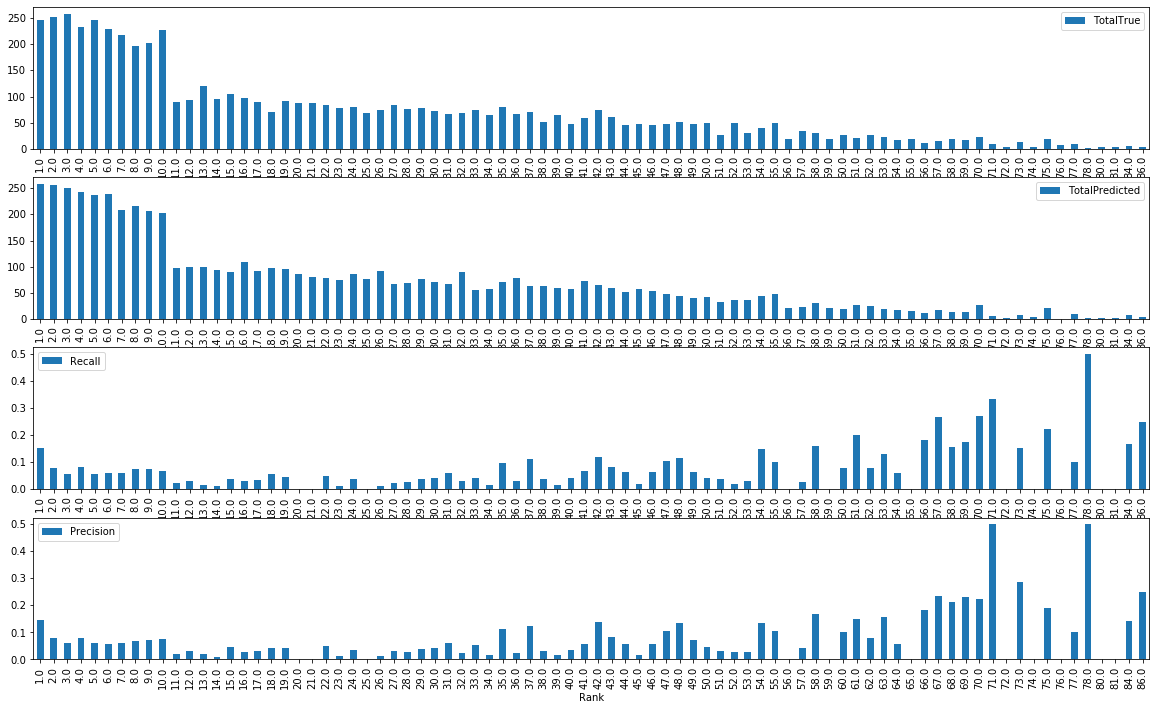

In [30]:
sumOfTruePositive = []
sumOfTrue = []
sumOfPredicted = []

for i in range(cm.shape[0]):
    x = cm[i,i]
    sumOfTruePositive.append(x)
    y = sum(cm[i,:])
    sumOfTrue.append(y)
    z = sum(cm[:,i])
    sumOfPredicted.append(z)
    
recall = np.array(sumOfTruePositive)/np.array(sumOfTrue)
precision = np.array(sumOfTruePositive)/np.array(sumOfPredicted)

resultDict = {'Rank':labels,'Recall':recall, 'Precision':precision, 'TotalTrue':sumOfTrue, 'TotalPredicted':sumOfPredicted}
resultDf = pd.DataFrame(resultDict)

fig = plt.figure(figsize=(20,12))
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

resultDf.plot.bar(x='Rank', y='TotalTrue',ax=ax1)
resultDf.plot.bar(x='Rank', y='TotalPredicted',ax=ax2)
resultDf.plot.bar(x='Rank', y='Recall',ax=ax3)
resultDf.plot.bar(x='Rank', y='Precision',ax=ax4)

### Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(criterion='entropy', n_estimators=30)
model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [32]:
model.score(X_test,y_test)

0.06656346749226007

In [33]:
y_predicted = model.predict(X_test)

In [34]:
from sklearn.metrics import confusion_matrix
labels = np.unique(y_test)
cm = confusion_matrix(y_test, y_predicted, labels=labels)

#pd.set_option('display.max_rows',74)
#pd.set_option('display.max_columns',74)
#pd.DataFrame(cm, index=labels, columns=labels)
#fig = plt.figure()
#ax = fig.add_subplot(111)
#ax.matshow(cm)

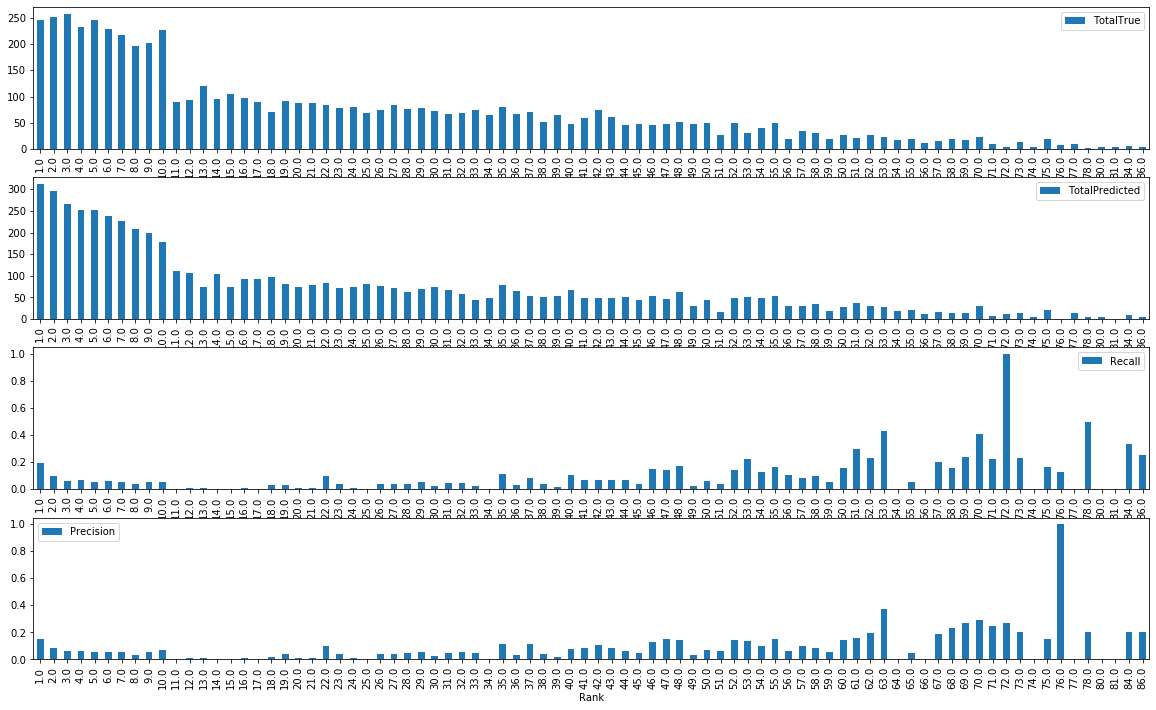

In [35]:
sumOfTruePositive = []
sumOfTrue = []
sumOfPredicted = []

for i in range(cm.shape[0]):
    x = cm[i,i]
    sumOfTruePositive.append(x)
    y = sum(cm[i,:])
    sumOfTrue.append(y)
    z = sum(cm[:,i])
    sumOfPredicted.append(z)
    
recall = np.array(sumOfTruePositive)/np.array(sumOfTrue)
precision = np.array(sumOfTruePositive)/np.array(sumOfPredicted)

resultDict = {'Rank':labels,'Recall':recall, 'Precision':precision, 'TotalTrue':sumOfTrue, 'TotalPredicted':sumOfPredicted}
resultDf = pd.DataFrame(resultDict)

fig = plt.figure(figsize=(20,12))
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

resultDf.plot.bar(x='Rank', y='TotalTrue',ax=ax1)
resultDf.plot.bar(x='Rank', y='TotalPredicted',ax=ax2)
resultDf.plot.bar(x='Rank', y='Recall',ax=ax3)
resultDf.plot.bar(x='Rank', y='Precision',ax=ax4)

### Tryout: Calculation Pseudo NDCG Score for comparison with RankNet Results

I tried to calculate a Pseudo NDCG Score for comparing the classificatin results to the RankNet Algorithm. Unfortunately this didn't work out nicely. I probably would need to do the sampling based on race_id in order to get a nice "Result-Set" structure. Like this I receive a lot of NDCG Score = 1.0 Results.

In [36]:
ndcgDf = X_test[['race_inf','race_y','gender']].copy()
ndcgDf['rank'] = y_test
ndcgDf['predicted'] = y_predicted

In [37]:
ndcgDf1 = ndcgDf.groupby(['race_inf','race_y','gender'],group_keys=False).apply(pd.DataFrame.sort_values,'rank')
ndcgDf1['realRank'] = ndcgDf1.groupby(['race_inf','race_y','gender'])['rank'].rank(ascending=True)
ndcgDf1['predRank'] = ndcgDf1.groupby(['race_inf','race_y','gender'])['predicted'].rank(ascending=True)
ndcgDf1['realRelevance'] = ndcgDf1.groupby(['race_inf','race_y','gender'])['rank'].rank(ascending=False)
ndcgDf1['realRelevance_V2'] = 1/ndcgDf1['realRank']
ndcgDf1['ndcgBaseIdeal'] = ndcgDf1['realRelevance_V2']/np.log2(ndcgDf1['realRank']+1)
ndcgDf1['ndcgBasePred'] = ndcgDf1['realRelevance_V2']/np.log2(ndcgDf1['predRank']+1)

In [38]:
ndcgDf1.head(15)

,race_inf,race_y,gender,rank,predicted,realRank,predRank,realRelevance,realRelevance_V2,ndcgBaseIdeal,ndcgBasePred
6835,0,2016.0,0,3.0,35.0,1.0,6.5,11.0,1.000000,1.000000,0.344010
6845,0,2016.0,0,15.0,2.0,2.0,1.0,10.0,0.500000,0.315465,0.500000
6846,0,2016.0,0,16.0,9.0,3.0,2.0,9.0,0.333333,0.166667,0.210310
6851,0,2016.0,0,21.0,56.0,4.0,10.5,8.0,0.250000,0.107669,0.070951
6852,0,2016.0,0,22.0,38.0,5.0,8.0,7.0,0.200000,0.077371,0.063093
6861,0,2016.0,0,32.0,34.0,6.0,5.0,6.0,0.166667,0.059368,0.064475
6865,0,2016.0,0,36.0,11.0,7.0,3.0,5.0,0.142857,0.047619,0.071429
6877,0,2016.0,0,50.0,56.0,8.0,10.5,4.0,0.125000,0.039433,0.035475
6878,0,2016.0,0,51.0,13.0,9.0,4.0,3.0,0.111111,0.033448,0.047853
6887,0,2016.0,0,56.0,44.0,10.5,9.0,1.5,0.095238,0.027029,0.028670


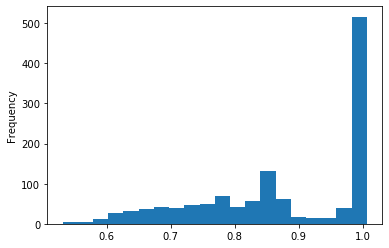

In [39]:
ndcgDf2 = ndcgDf1.groupby(['race_inf','race_y','gender'],group_keys=False)[['ndcgBaseIdeal','ndcgBasePred']].sum()
ndcgScores = ndcgDf2['ndcgBasePred'] / ndcgDf2['ndcgBaseIdeal']
ndcgScores.plot.hist(bins=20, alpha=1)

### Logistic Regression

Logistic Regression doesn't work, because there aren't sufficient cases for each combination of categorical variables (?). Some subj_id s only exist once. Also some test-dataset subj_id aren't contained in the train-dataset. Correct(?)

In [40]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

In [41]:
model.fit(X_train,y_train)

C:\Users\finns\Anaconda3\envs\Deep Learning CAS 2020\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In order to be able to do a logistic regression I delete the variable "subj_id", "race_y" and "race_inf" from the test/train datasets in order for the model to converge. 

In [56]:
dfLog = df[['age_y','nat','gender','rank']]
#'race_inf',
dfLogLe = dfLog.copy()
dfLogLe['nat'] = le.fit_transform(dfLogLe['nat'])
#dfLogLe['race_inf'] = le.fit_transform(dfLogLe['race_inf'])
dfLogLe['gender'] = le.fit_transform(dfLogLe['gender'])

from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    dfLogLe.drop(['rank'],axis='columns'),
    dfLogLe['rank'],
    random_state=42,
    test_size=0.2)

In [57]:
model.fit(X_train1,y_train1)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [58]:
model.score(X_test1, y_test1)

0.048331613347093225

In [59]:
y_predicted1 = model.predict(X_test1)

In [60]:
from sklearn.metrics import confusion_matrix
labels = np.unique(y_test1)
cm = confusion_matrix(y_test1, y_predicted1, labels=labels)

C:\Users\finns\Anaconda3\envs\Deep Learning CAS 2020\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


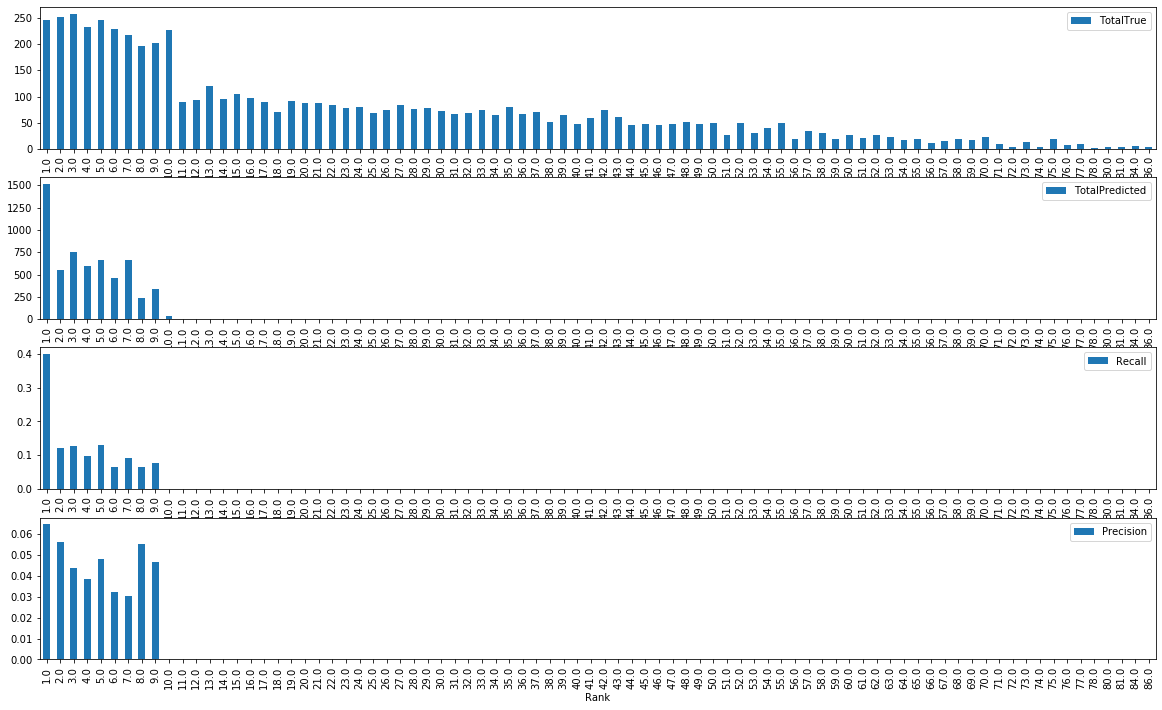

In [61]:
sumOfTruePositive = []
sumOfTrue = []
sumOfPredicted = []

for i in range(cm.shape[0]):
    x = cm[i,i]
    sumOfTruePositive.append(x)
    y = sum(cm[i,:])
    sumOfTrue.append(y)
    z = sum(cm[:,i])
    sumOfPredicted.append(z)
    
recall = np.array(sumOfTruePositive)/np.array(sumOfTrue)
precision = np.array(sumOfTruePositive)/np.array(sumOfPredicted)

resultDict = {'Rank':labels,'Recall':recall, 'Precision':precision, 'TotalTrue':sumOfTrue, 'TotalPredicted':sumOfPredicted}
resultDf = pd.DataFrame(resultDict)

fig = plt.figure(figsize=(20,12))
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

resultDf.plot.bar(x='Rank', y='TotalTrue',ax=ax1)
resultDf.plot.bar(x='Rank', y='TotalPredicted',ax=ax2)
resultDf.plot.bar(x='Rank', y='Recall',ax=ax3)
resultDf.plot.bar(x='Rank', y='Precision',ax=ax4)

### Support Vector Machine

In [48]:
from sklearn.svm import SVC
model = SVC(gamma = 0.01)
# gamma = 0.01
# C=1.0, gamma = 'auto', kernel = 'rbf'
# Support Vector machine tries to maximize the "margin" between data points. 
# Gamma determines how many points are considered for the Margin. 
# High Gamma means only points close to the partitioning vecotr. 
# Low Gamma means also points that are farther away are considered. High gamma tends to do more overfitting. 


In [49]:
model.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [50]:
model.score(X_test, y_test)

0.048331613347093225

In [51]:
y_predicted = model.predict(X_test)

In [52]:
from sklearn.metrics import confusion_matrix
labels = np.unique(y_test)
cm = confusion_matrix(y_test, y_predicted, labels=labels)

#pd.set_option('display.max_rows',74)
#pd.set_option('display.max_columns',74)
#pd.DataFrame(cm, index=labels, columns=labels)
#fig = plt.figure()
#ax = fig.add_subplot(111)
#ax.matshow(cm)

C:\Users\finns\Anaconda3\envs\Deep Learning CAS 2020\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


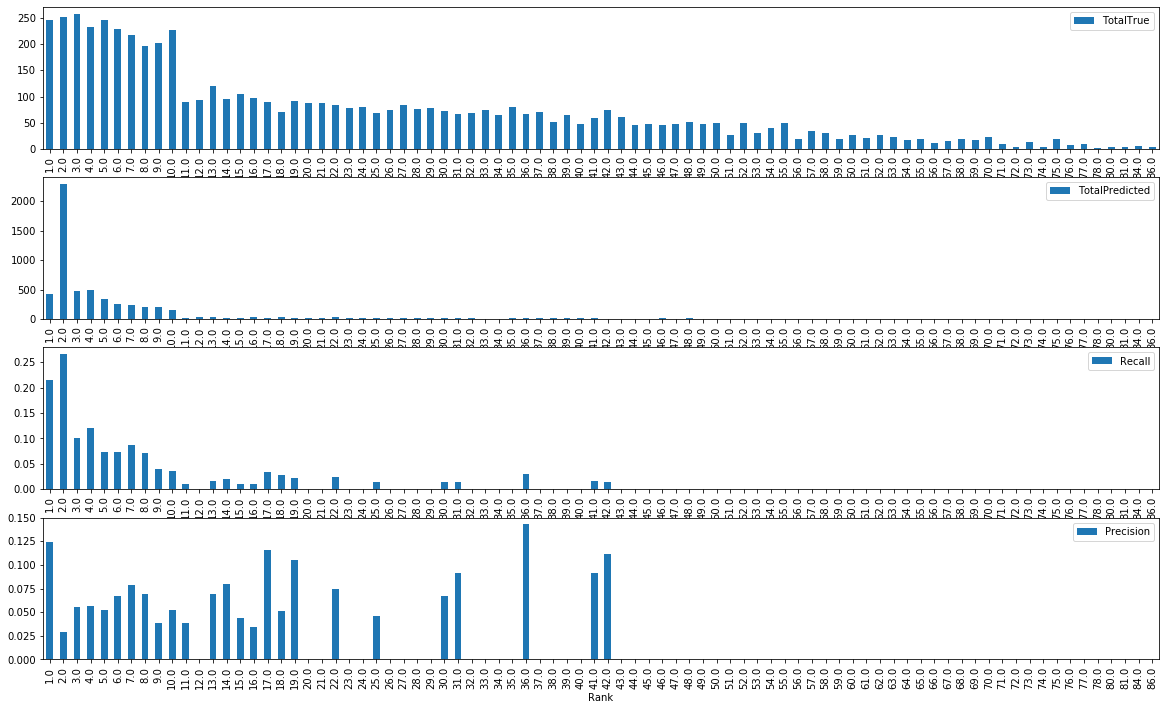

In [53]:
sumOfTruePositive = []
sumOfTrue = []
sumOfPredicted = []

for i in range(cm.shape[0]):
    x = cm[i,i]
    sumOfTruePositive.append(x)
    y = sum(cm[i,:])
    sumOfTrue.append(y)
    z = sum(cm[:,i])
    sumOfPredicted.append(z)
    
recall = np.array(sumOfTruePositive)/np.array(sumOfTrue)
precision = np.array(sumOfTruePositive)/np.array(sumOfPredicted)

resultDict = {'Rank':labels,'Recall':recall, 'Precision':precision, 'TotalTrue':sumOfTrue, 'TotalPredicted':sumOfPredicted}
resultDf = pd.DataFrame(resultDict)

fig = plt.figure(figsize=(20,12))
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

resultDf.plot.bar(x='Rank', y='TotalTrue',ax=ax1)
resultDf.plot.bar(x='Rank', y='TotalPredicted',ax=ax2)
resultDf.plot.bar(x='Rank', y='Recall',ax=ax3)
resultDf.plot.bar(x='Rank', y='Precision',ax=ax4)

In [54]:
#Following Code chunks work a lot better to calculate precision and recall from the confusion matrix. Above I used a loop to do the same thing.

#np.diagonal(cm)
#np.diagonal(cm)/cm.sum(axis=1)
#cm.sum(axis=1)

In [55]:
# Explanation for SVM results: 
# https://stats.stackexchange.com/questions/125353/output-of-scikit-svm-in-multiclass-classification-always-gives-same-label

### Tutorials
https://www.youtube.com/watch?v=PHxYNGo8NcI => Decision Tree <br>
https://www.youtube.com/watch?v=ok2s1vV9XW0 => Random Forest <br>
https://www.youtube.com/watch?v=9yl6-HEY7_s => Dummy Variables and One Hot Encoding <br>
https://www.youtube.com/watch?v=J5bXOOmkopc => Logistic Regression <br>
https://www.youtube.com/watch?v=FB5EdxAGxQg => Support Vector Machine <br>
https://www.datacamp.com/community/tutorials/deep-learning-python?utm_source=adwords_ppc&utm_campaignid=1655852085&utm_adgroupid=61045434462&utm_device=c&utm_keyword=%2Bkeras%20%2Btutorial&utm_matchtype=b&utm_network=g&utm_adpostion=&utm_creative=318880582449&utm_targetid=kwd-321066923947&utm_loc_interest_ms=&utm_loc_physical_ms=1003297&gclid=EAIaIQobChMIgZSiw_vQ6AIVibHtCh29xwhXEAAYASAAEgJfQvD_BwE => Deep Learning <br>
https://mlexplained.com/2019/05/27/learning-to-rank-explained-with-code/ => LambdaRank  <br>
https://towardsdatascience.com/evaluate-your-recommendation-engine-using-ndcg-759a851452d1 => ndcg Score